### Notebook for Understanding Basics of Conjugate Priors 

In [2]:
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import scipy.stats as sstat
import seaborn as sns # if necessary 

#### Check Beta Distribution which is Conjugate to Bernoulli Likelihood  

Check Beta Distribution definition in [Wolfram Alpha](http://mathworld.wolfram.com/BetaDistribution.html) for more.

Probability density function is defined as-- 

$P\left(x| a, b \right) = \frac{1}{B(a, b)}\, x^{a-1}\, \left(1-x \right)^{b-1}$, where <br>

$B(a, b) = \frac{\Gamma (a) \Gamma (b)}{\Gamma (a + b)}$; and $x \in \left[0, 1\right], a, b > 0$. 



Beta distribution is conjugate to Bernoulli likelihood. 
Let's see :

Bernoulli likelihood is given by : $p(x | \theta) =  \theta ^{N_1} \, \left(1-\theta \right)^{N_0}$. Bernoulli distribution is a discrete distribution with 2 possible outcomes labelled by $N_1 = 1$ (success) and $N_0 = 0$ (failure), where success occurs with probability $\theta$ and failure with probability $\left(1-\theta \right)$. 

Multiplying Beta prior and Bernoulli Likelihood gives us -- 

$p (\theta) \times p (x | \theta) \propto  \theta ^{a-1}\, \left(1-\theta \right)^{b-1} \times \theta ^{N_0} \, \left(1-\theta \right)^{N_1}$, which essentially is beta distribution with different hyperparameters-- $ B\left(a + N_1, b + N_0 \right)$.


Here it is important to note that Binomial distribution (can be roughly thought of as an extension of Bernoulli distribution) is also conjugate to the Beta distribution. 

**Short note on Binomial Distribution** (This could be important to understand the later part of calculation including Pymc3). 

Bernoulli random variable has 2 possible outcomes 0 or 1. A binomial distribution is the sum of _independent_ and _identically_ distributed Bernoulli random variables. Definition of Binomial distribution according to the Wolfram page is -- Binomial distribution gives the discrete probability distribution $P_p \left(n|N \right)$ of obtaining exactly n success out of N Bernoulli trials(where the result of each trial is true with probability p). So the binomial distribution is given by 

$P_p \left(n| N \right) = \frac{N!}{n! (N-n)!} p^n (1-p)^{N-n}$. 

Let's see an example! If I have a coin which when tossed the probability it lands on heads is $p$. Now, if I toss the coin five times, getting 5 heads will have a probability $p^5$, given each coin toss is independent and they all have the identical probability. What is the probability that we get exactly 3 heads ? This can be obtained using the previous Binomial distribution $\frac{5!}{3! 2!} p^3 (1-p)^2$.  

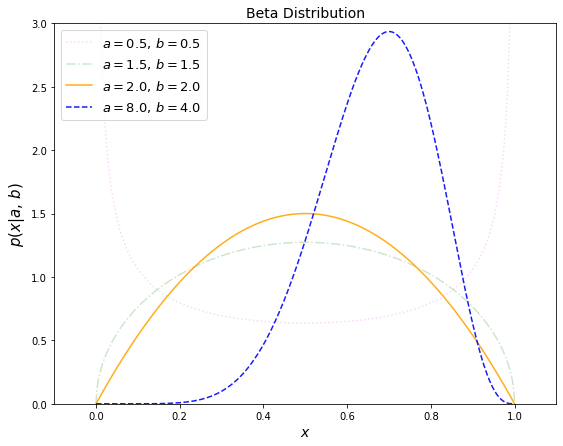

In [4]:
a_vals = [0.5, 1.5, 2.0, 8]
b_vals = [0.5, 1.5, 2.0, 4]
linestyles = [':', '-.', '-', '--']
colors = ['#EE82EE', '#008000', '#FFA500', '#0000FF']
alphas = [0.3, 0.2, 0.9, 0.9]

x = np.linspace(0, 1, 500)

plt.figure(figsize=(9, 7))

for a, b, l, c, alps in zip(a_vals, b_vals, linestyles, colors, alphas):
    betadist = sstat.beta(a, b)
    betapdf = betadist.pdf(x)
    
    plt.plot(x, betapdf, linestyle=l, color=c, 
            label=r'$a = %.1f, \, b = %.1f $'%(a, b), alpha = alps)
    
plt.xlim(-0.1, 1.1)
plt.ylim(0, 3)

plt.xlabel('$x$', fontsize=14)
plt.ylabel(r'$p(x | a,\,  b)$', fontsize=15)
plt.title('Beta Distribution', fontsize=14)

plt.legend(loc=0, fontsize=13)
plt.savefig('./BetaDis.png', dpi=300)
plt.show()

#### Normal and Inverse Gamma as Conjugate Prior 

Likelihood is Normal Distribution with a known mean $(\mu)$. Assuming there are $n$ data points <br>

$f(x_1, x_2, ...., x_n | \mu , \sigma ^2) = \prod _{i=1} ^{n} \frac{1}{\sqrt{2\pi \sigma ^2}} \text{exp} \left( -\frac{(x_i - \mu)^2}{2\sigma ^2}\right)$. This can be simplified as -- <br>

$f(x | \mu , \sigma ^2) = \left(2\pi \right)^{-\frac{n}{2}} \, \left(\sigma ^2\right)^{-\frac{n}{2}} \text{exp} \left(-\frac{1}{\sigma ^2} \sum _i ^n \frac{(x_i - \mu )^2}{2\sigma ^2}\right)$. Let's see how Inverse Gamma distribution looks like <br>

$f(y | \alpha , \beta) = \frac{\beta ^{\alpha}}{\Gamma (\alpha)}\,  y^{-\alpha - 1}\,  \text{exp} \left(\frac {-\beta}{y} \right)$. 

So now we use this as prior distribution with $\sigma ^2$ as parameter-- <br>

$g(\sigma ^2) = \frac{\beta ^{\alpha}}{\Gamma (\alpha)} \left(\sigma  ^2 \right)^{-\alpha -1}\, \text{exp}\left(-\frac{\beta}{\sigma ^2}\right) $. 

Now, Posterior $\propto$  prior $\times$ likelihood. We ignore the constant terms, i.e., terms without $\sigma$. 

posterior $ \propto \left(\sigma ^2 \right)^{-\alpha -1 - \frac{n}{2}}\,  \text{exp} \left(-\frac{\beta}{\sigma ^2} - \left(-\frac{1}{\sigma ^2} \sum _i ^n \frac{(x_i - \mu )^2}{2\sigma ^2} \right) \right)$. This is actually another Inverse Gamma Distribution with parameters --

$\left(\alpha + \frac{n}{2} \right), \left(\beta + \sum _i ^n \frac{(x_i - \mu )^2}{2\sigma ^2}\right)$

### Beta Posterior Update Example

* Toss coin (This is basically a Bernoulli trial, include some probability of success). 
* Count the number of success (heads in coin flip). 
* Add these numbers to update beta distribution. 

Beta and Binomial distributions are conjugate to each other.  Knowing that beta and binomial are conjugate to each other, we can plot the updates of beta posterior as we collect more and more data. 

If we go back to the formula above we can see that the update rule for beta posterior is to add number of success to a and failures to b. Such that $B(a, b) \rightarrow B(a+N_1, b+N_0)$.   


In [2]:


def plot_coin_flip_posterior(success = 0.4): # choose probability of heads to be 0.3 # Biased coin.  
    # Beta distribution is the conjugate prior of the binomial distribution
    betadist = sstat.beta
    num_trials = [0, 2, 10, 50, 100, 200, 400, 600, 750, 1000]
    trials = sstat.bernoulli.rvs(success, size=num_trials[-1]) # create the array of bernoulli trials. 
    x = np.linspace(0.001, 1, 200)
    plt.figure(figsize=(12, 11))
    # For the already prepared, I'm using Binomial's conj. prior.
    for i, N in enumerate(num_trials):
        sx = plt.subplot(len(num_trials) / 2, 2, i + 1)
        plt.setp(sx.get_yticklabels(), visible=False)
        heads = trials[:N].sum() # count the number of ones 
        y = betadist.pdf(x,  1 + heads,  1 + N - heads) # starts of with uniform prior 
        # this term will be updated after counting success (heads) and failures. 
        
        plt.plot(x, y, label="%d tosses, %d heads" % (N, heads))
        plt.fill_between(x, 0, y, color="purple", alpha=0.4)
        plt.axvline(success, 0, 0.95, color="k", linestyle="--", lw=1, label='Bernoulli Success: %.1f'%(success))
        leg = plt.legend(loc='best', fontsize=11, fancybox=True, framealpha=0.5)
        plt.autoscale(tight=True)
        plt.ylim([0.01, 1*np.amax(y) + 2.])

    plt.suptitle(
        r"Bayesian updating of posterior probability $B(1, 1) \rightarrow B(1 + N_{1i}, 1 + N_{0i})$",
        fontsize=13)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
#     plt.savefig('./Bayesian_posterior_update.png', dpi=300)

In [85]:
# plot_coin_flip_posterior(success = 0.4)

#### Plot the same plots Using Celluloid

In [16]:
from celluloid import Camera

success = 0.4
num_trials = [0, 2, 10, 50, 100, 200, 400, 600, 750, 1000]
betadist = sstat.beta
trials = sstat.bernoulli.rvs(success, size=num_trials[-1]) # create the array of bernoulli trials. 


fig = plt.figure(figsize=(12, 7))
camera = Camera(fig)

x = np.linspace(0.001, 1, 200)
 
for i, N in enumerate(num_trials):
    heads = trials[:N].sum() 
    y = betadist.pdf(x,  1 + heads,  1 + N - heads)     
#     plt.plot(x, y, label="%d tosses, %d heads" % (N, heads))
    plt.plot(x, y, color='red', alpha=0.3)
    plt.fill_between(x, 0, y, color="purple", alpha=0.4)
    plt.axvline(success, 0., 0.70, color="k", linestyle="--", lw=1,)
    plt.text(0.4, 21, 'Bernoulli Success: %.1f'%(success), fontsize=13)
    plt.ylabel('PDF: Beta Distribution', fontsize=14)
    plt.xlabel('x', fontsize=16)
    plt.autoscale(tight=True)
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    label = ["%d tosses, %d heads" % (N, heads)]
    plt.legend(label, loc='best', fontsize=14, fancybox=True, framealpha=0.5)
    camera.snap()

animation = camera.animate(interval=1000, )
animation.save('beta_post_min.gif', writer = 'imagemagick', dpi=200)

### Use [PyMC3](https://docs.pymc.io/) for a More Comprehensive Explanation .  

In [4]:
import pymc3

def get_samples(alpha, beta, num_samples):
    with pymc3.Model() as model:
        b = pymc3.Beta('b', alpha=alpha, beta=beta)
        tr = pymc3.sample(num_samples)
    return tr.get_values('b')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:03<00:00, 5715.72draws/s]


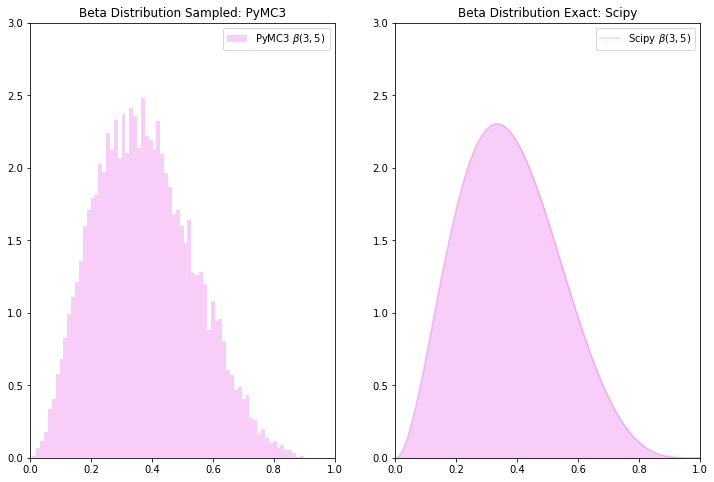

In [21]:
### Plot a sampled Beta Distribution and Real Beta Distribution 

num_samples = 5000
alpha = 3
beta = 5
samples = get_samples(alpha, beta, num_samples)
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)

plt.hist(samples, bins=int(np.sqrt(num_samples)), density=True,  
         color='violet', alpha=0.4, label=r'PyMC3 $\beta (%d, %d)$'%(alpha, beta))
plt.legend(loc='best')
plt.xlim(0., 1.)
plt.ylim(0., 3)
plt.title("Beta Distribution Sampled: PyMC3")

plt.subplot(1, 2, 2)
xax = np.linspace(0., 1.01, 200)
ybeta = sstat.beta.pdf(xax, alpha, beta)
plt.plot(xax, sstat.beta.pdf(xax, alpha, beta), linestyle='-', color='violet', alpha = 0.4, 
         label=r'Scipy $\beta (%d, %d)$'%(alpha, beta))

plt.fill_between(xax, 0, ybeta, color='violet', alpha=0.4)
plt.legend(loc='best')
plt.xlim(0., 1.)
plt.ylim(0., 3)

plt.title("Beta Distribution Exact: Scipy")
plt.show()

In [42]:
success = 0.4 # success probability in each trials
n_samp = 20
data = sstat.bernoulli.rvs(success, size=n_samp)
heads = data.sum() # add the number of 1's (i.e. total number of success). 
print ("total number of success : ", heads)
# maximum likelihood for bernoulli distribution = success/total trials

print ("maximum likelihood estimation: ", float(heads)/float(n_samp))

total number of success :  9
maximum likelihood estimation:  0.45


In [5]:
### Define a Model in PyMC3
### Check here [https://thepythonguru.com/how-to-build-probabilistic-models-with-pymc3-in-bayesian/] for 
### a better description on pymc3 model building. 

def model_pymc3(d):
    with pymc3.Model() as model: 
        bprior = pymc3.Beta('bprior', alpha=1, beta=1) # we choose a beta prior for our parameter theta
        bernoulli_likelihood = pymc3.Bernoulli('bernoulli', p = bprior, observed = d)
    return model

In [31]:
### Let's write the previous code outside function to see what's goinf on 

# with pymc3.Model() as model:
#     bprior = pymc3.Beta('bp', alpha=1, beta=1)
#     likelih = pymc3.Bernoulli('likelihood', p = bprior, observed = data)
#     trace = pymc3.sample(6000, )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bp]
Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [00:04<00:00, 5968.64draws/s]


In [7]:
import arviz as az

In [33]:
# az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bp,0.41,0.103,0.216,0.596,0.001,0.001,10104.0,10104.0,10210.0,16583.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10644a1e10>,
      dtype=object)

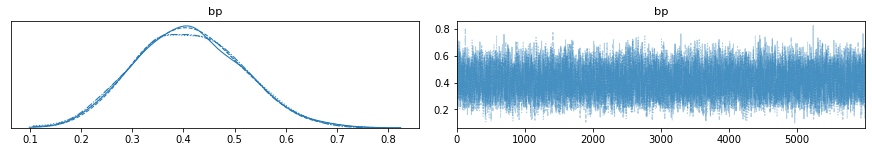

In [35]:
# pymc3.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1063dd8748>],
      dtype=object)

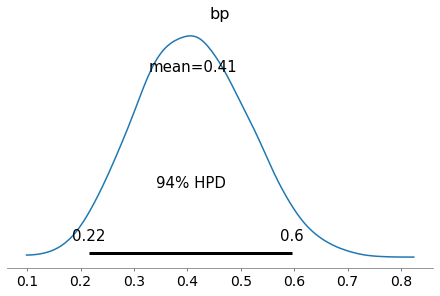

In [34]:
# az.plot_posterior(trace)

In [44]:
### Check the map using pymc3 

# check_model = model_pymc3(data)
# map_estimate = pymc3.find_MAP(model=check_model)
# print ("Map using PyMC3: ", map_estimate)

logp = -13.863, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 2350.41it/s]

Map using PyMC3:  {'theta_logodds__': array(-0.20067069), 'theta': array(0.45)}


### Compare the PyMC3 MAP Estimation with the Real Value

In [8]:

# def cal_trace_pymc3(sample_size, success_prob):
#     bernoulli_trials = sstat.bernoulli.rvs(success_prob, size=sample_size)
#     # generate bernoulli trials of the given sample size
#     model_in_pymc3 = model_pymc3(bernoulli_trials) # defined before 
#     with model_in_pymc3:
# #         start = pymc3.find_MAP() # Not sugested for high dimensional posterior 
#         # maximum a posteriori for the model would be the starting point for drawing sample from the posterior
# #         trace = pymc3.sample(15000, start=start)
#         trace = pymc3.sample(15000, )
#     return trace.get_values('bprior'), bernoulli_trials 
#     # return the values of beta prior and the observation itself  

In [ ]:
def cal_trace_pymc3(sample_size, success_prob):
    bernoulli_trials = sstat.bernoulli.rvs(success_prob, size=sample_size)
    # generate bernoulli trials of the given sample size
    model_in_pymc3 = model_pymc3(bernoulli_trials) # defined before 
    with model_in_pymc3:
        trace = pymc3.sample(15000, )
    return trace.get_values('bprior'), bernoulli_trials 
    # return the values of the generated samples from posterior and the observation itself  

In [36]:
# n_samples = [20,50,100,500,5000]
# success_prob = 0.4
# def get_theta_histograms():    
#     histograms = dict()
#     data = dict()
#     bins = np.arange(0.,1.01,0.01)
#     for i, N in enumerate(n_samples):
#         #prior_trace, observed_data = get_traces(N, theta_unk=theta_unk)
#         prior_trace, observed_data = cal_trace_pymc3(N, success_prob)
#         hist, bins = np.histogram(prior_trace, bins=bins)
#         histograms[N] = hist
#         data[N] = observed_data
#     return histograms, bins, data

# histograms, bins, data = get_theta_histograms()

In [9]:
n_samples = [20,50,100,500,5000]
success_prob = 0.4
def get_theta_histograms():    
    all_traces = dict()
    data = dict()
    bins = np.arange(0.,1.01,0.01)
    for i, N in enumerate(n_samples):
        #prior_trace, observed_data = get_traces(N, theta_unk=theta_unk)
        prior_trace, observed_data = cal_trace_pymc3(N, success_prob)
#         hist, bins = np.histogram(prior_trace, bins=bins)
#         histograms[N] = hist
        data[N] = observed_data
        all_traces[N] = prior_trace
    return all_traces, bins, data

all_traces, bins, data = get_theta_histograms()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bprior]
Sampling 4 chains, 0 divergences: 100%|██████████| 62000/62000 [00:12<00:00, 4871.26draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bprior]
Sampling 4 chains, 0 divergences: 100%|██████████| 62000/62000 [00:13<00:00, 4742.00draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bprior]
Sampling 4 chains, 0 divergences: 100%|██████████| 62000/62000 [00:13<00:00, 4663.77draws/s]
The acceptance probability does not match the target. It is 0.8786036723064063, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bprior]
Sampling 4 chains, 0 divergences:

<Figure size 720x1152 with 0 Axes>

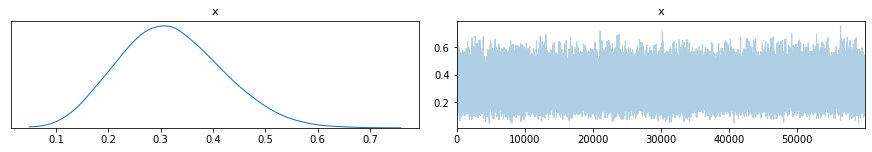

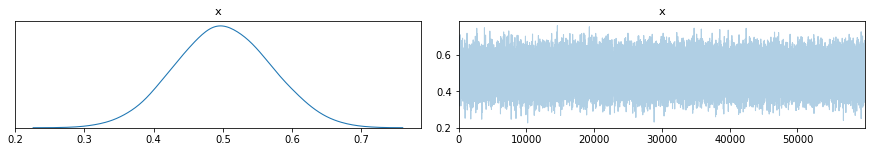

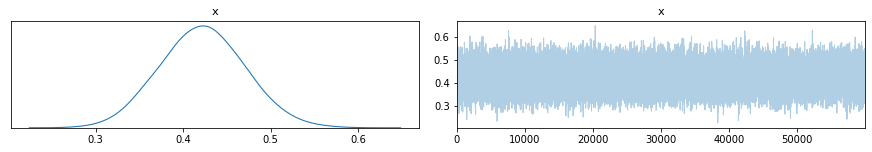

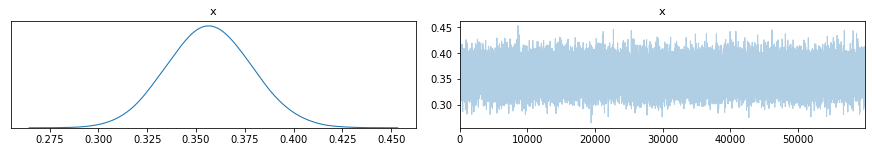

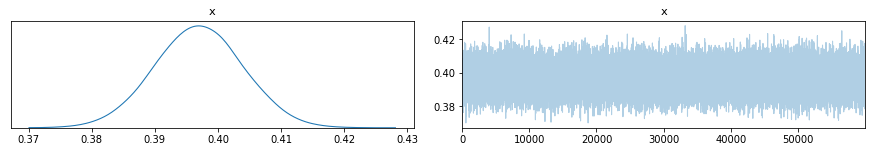

In [11]:
fig = plt.figure(figsize=(10,16))
for i, N in enumerate(n_samples):
    in_trace = all_traces[N]
    tr_x = pymc3.traceplot(in_trace,)    
    fig = plt.gcf() # to get the current figure...
    fig.savefig("trace_bprior%d.png"%(i), dpi=200) # and save    

In [ ]:
# def plot_theta_histograms(histograms, bins, data):
#     x = np.linspace(0, 1, 100)
#     theta_unk = 0.3
#     plt.figure(figsize=(10,16))
#     for i, N in enumerate(n_samples):
#         ax = plt.subplot(len(n_samples), 2, (i*2)+1)
# #         plt.setp(ax.get_yticklabels(), visible=False)
#         hist = histograms[N]
# #         print ("what is hist: ", type(hist))
# #         print ("hist shape: ", hist.shape)
# #         print ("few hists: ", hist[85:90])
# #         print ("what is bins: ", type(bins))
# #         print ("bins shape: ", bins.shape)
# #         print ("bins length: ", len(bins))
# #         print ("few bins: ", bins[85:90])
#         width = (bins[1] - bins[0])
#         center = (bins[:-1] + bins[1:]) / 2
# #         print ("length of center", len(center))
# #         print ("few centers: ", center[85:90])
#         ax.bar(center, hist, align='center', width=width)
# #         ax.hist(hist, bins=bins)
#         plt.xlim([0., 1.0])
#         ax.set_xlabel(r'$\theta$', fontsize=12)
#         ax.set_ylabel(r'$p(\theta)$', fontsize=12)
        
#         ax = plt.subplot(len(n_samples), 2, (i*2) + 2)
#         plt.setp(ax.get_yticklabels(), visible=False)
#         observed_data = data[N]
#         k = observed_data.sum(); n=len(observed_data)
#         ax.plot(bins, sstat.beta.pdf(bins, k+1, n-k+1), 'r-', lw=2, alpha=0.6, label='beta pdf')
#         ax.set_xlabel("$theta$")
#         ax.set_ylabel("$p(theta)$")
# #     plt.suptitle("MCMC sample histograms and exact solution for different $n$")
#     #plt.legend()
#     plt.show()

In [44]:
def plot_dist_pymc3(all_traces, bins, data):
    fig = plt.figure(figsize=(10, 16))
    for i, N in enumerate(n_samples):
        sx = plt.subplot(len(n_samples), 2, (i*2)+1)
        in_trace = all_traces[N]
        sns.distplot(in_trace, bins=int(np.sqrt(N)), norm_hist=True, hist=False,)
        plt.ylabel(r'$p(\theta)$: From PyMC3', fontsize=12)
        plt.setp(sx.get_yticklabels(), visible=False)
        
        sx1 = plt.subplot(len(n_samples), 2, (i*2) + 2)
        observed_data = data[N]
        heads = observed_data.sum()
        n=len(observed_data)
        plt.plot(bins, sstat.beta.pdf(bins, heads+1, n-heads+1), 'r-', lw=2, alpha=0.6, label='')
        plt.setp(sx1.get_yticklabels(), visible=False)
        plt.ylabel(r'$p(\theta)$: From Scipy', fontsize=12)
        label = ["%d tosses, \n %d heads" % (n, heads)]
        plt.legend(label, loc = 'best', fontsize=12)

        plt.autoscale(tight=True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.savefig("Beta_post_pymc3.png", dpi=300)
    plt.show()

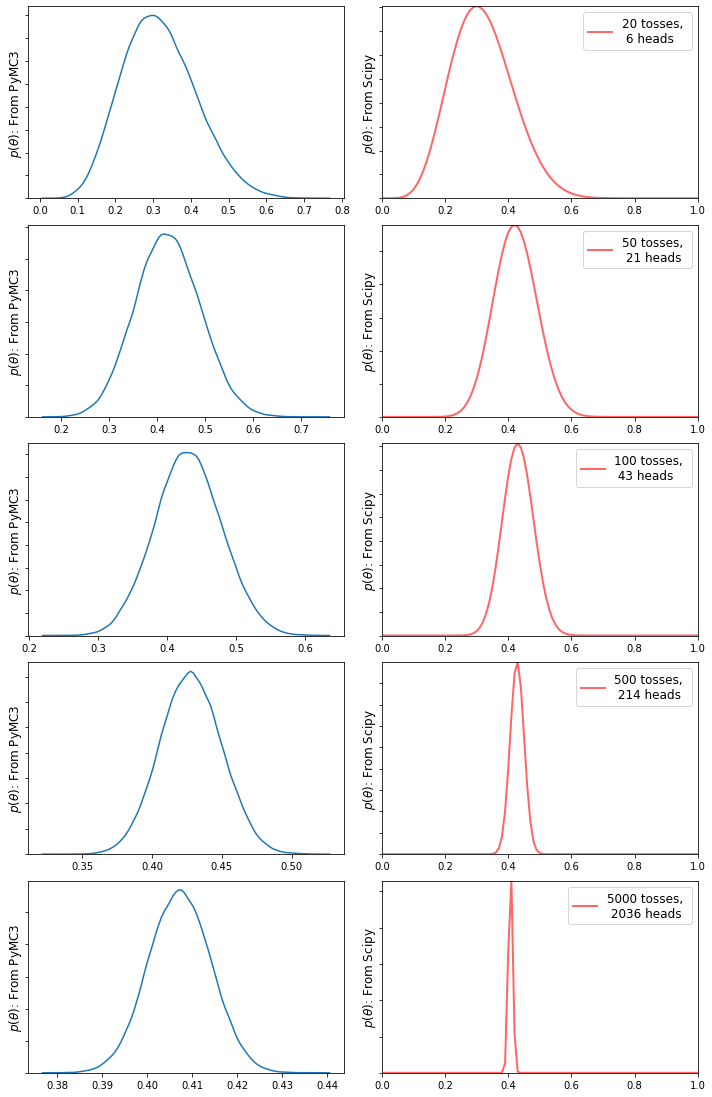

In [22]:
plot_dist_pymc3(all_traces, bins, data)

/home/suvo/Videos/Jupyter/jupyternb/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/suvo/Videos/Jupyter/jupyternb/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


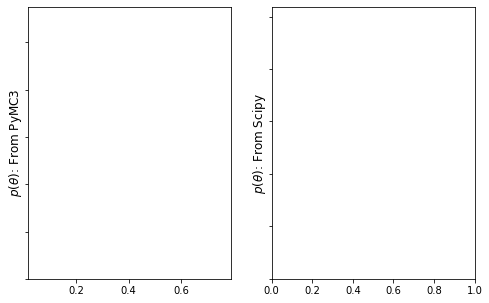

In [13]:
from celluloid import Camera
fig = plt.figure(figsize=(8, 5))
camera = Camera(fig)

for i, N in enumerate(n_samples):
    i=0
    sx = plt.subplot(1, 2, i+1)
    in_trace = all_traces[N]
    
    sns.distplot(in_trace, bins=int(np.sqrt(N)), norm_hist=True, hist=False,)
    plt.ylabel(r'$p(\theta)$: From PyMC3', fontsize=12)
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.autoscale(tight=True,axis='both')

    sx1=plt.subplot(1, 2, i+2)
    observed_data = data[N]
    heads = observed_data.sum()
    n=len(observed_data)
    plt.plot(bins, sstat.beta.pdf(bins, heads+1, n-heads+1), 'r-', lw=2, alpha=0.6, label='From Scipy')
    plt.setp(sx1.get_yticklabels(), visible=False)
    plt.autoscale(tight=True,axis='both')
    plt.ylabel(r'$p(\theta)$: From Scipy', fontsize=12)
    label = ["%d tosses, \n %d heads" % (n, heads)]
    plt.legend(label, loc = 'best', fontsize=12)
    plt.autoscale(tight=True,axis='both')
    camera.snap()

animation = camera.animate(interval=1000, )
animation.save('beta_post_PyMC3.gif', writer = 'imagemagick', dpi=200)

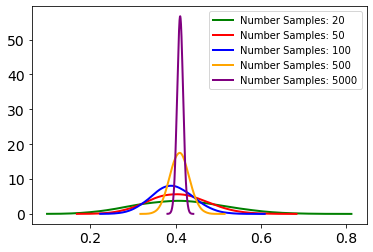

In [67]:
# for i, N in enumerate(n_samples):
#         in_trace = all_traces[N]
# #         print (az.summary(in_trace))
#         color = ["green", "red", "blue", "orange", "purple"]
#         az.plot_kde(in_trace, label='Number Samples: %d'%(N), 
#                    plot_kwargs={"linewidth": 2, "color": "%s"%(color[i])},)